# Semantic segmentation MobileNetV2

## Introduction
Image segmentation is the process of classifying each pixel in an image belonging to a certain class and hence can be thought of as a classification problem per pixel. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset used is the ADE20K Dataset which contains more than 20K scene-centric images exhaustively annotated with objects and object parts. Specifically, the dataset is divided into 20K images for training, 2K images for validation, and another batch of held-out images for testing. There are totally 150 semantic categories included for evaluation, which include stuffs like sky, road, grass, and discrete objects like person, car, bed. The type of data we are going to manipulate consist in:

*   RGB jpg images
*   1 channel jpg masks where each pixel has a value from 0 to 150 defining its class
*   150 possible classes + 1 undefined

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-8e5719yn
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-8e5719yn
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ff4ddd4609f76d8b7d085033a9b4cd9a3c6d26bd_-cp36-none-any.whl size=164220 sha256=36bb87d144f6f0579a74c84fa4fb973531238ac82a3a7220970525879f24b74c
  Stored in directory: /tmp/pip-ephem-wheel-cache-isdh26dj/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.7MB 9.4MB/s 


## Environment

In [ ]:
import tensorflow as tf
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.3.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

## Download the dataset

In [ ]:
def check_sha1(filename, sha1_hash):
    """Check whether the sha1 hash of the file content matches the expected hash.
    Parameters
    ----------
    filename : str
        Path to the file.
    sha1_hash : str
        Expected sha1 hash in hexadecimal digits.
    Returns
    -------
    bool
        Whether the file content matches the expected hash.
    """
    sha1 = hashlib.sha1()
    with open(filename, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)

    sha1_file = sha1.hexdigest()
    l = min(len(sha1_file), len(sha1_hash))
    return sha1.hexdigest()[0:l] == sha1_hash[0:l]

def download(url, path=None, overwrite=False, sha1_hash=None):
    """Download an given URL
    Parameters
    ----------
    url : str
        URL to download
    path : str, optional
        Destination path to store downloaded file. By default stores to the
        current directory with same name as in url.
    overwrite : bool, optional
        Whether to overwrite destination file if already exists.
    sha1_hash : str, optional
        Expected sha1 hash in hexadecimal digits. Will ignore existing file when hash is specified
        but doesn't match.
    Returns
    -------
    str
        The file path of the downloaded file.
    """
    if path is None:
        fname = url.split('/')[-1]
    else:
        path = os.path.expanduser(path)
        if os.path.isdir(path):
            fname = os.path.join(path, url.split('/')[-1])
        else:
            fname = path

    if overwrite or not os.path.exists(fname) or (sha1_hash and not check_sha1(fname, sha1_hash)):
        dirname = os.path.dirname(os.path.abspath(os.path.expanduser(fname)))
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        print('Downloading %s from %s...'%(fname, url))
        r = requests.get(url, stream=True)
        if r.status_code != 200:
            raise RuntimeError("Failed downloading url %s"%url)
        total_length = r.headers.get('content-length')
        with open(fname, 'wb') as f:
            if total_length is None: # no content length header
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk: # filter out keep-alive new chunks
                        f.write(chunk)
            else:
                total_length = int(total_length)
                for chunk in tqdm(r.iter_content(chunk_size=1024),
                                  total=int(total_length / 1024. + 0.5),
                                  unit='KB', unit_scale=False, dynamic_ncols=True):
                    f.write(chunk)

        if sha1_hash and not check_sha1(fname, sha1_hash):
            raise UserWarning('File {} is downloaded but the content hash does not match. ' \
                              'The repo may be outdated or download may be incomplete. ' \
                              'If the "repo_url" is overridden, consider switching to ' \
                              'the default repo.'.format(fname))

    return fname

def download_ade(path, overwrite=False):

    """Download ADE20K
    Parameters
    ----------
    path : str
      Location of the downloaded files.
    overwrite : bool, optional
      Whether to overwrite destination file if already exists.
    """
    if not os.path.exists(path):
        os.mkdir(path)
    _AUG_DOWNLOAD_URLS = [
      ('http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip', '219e1696abb36c8ba3a3afe7fb2f4b4606a897c7'),
      ('http://data.csail.mit.edu/places/ADEchallenge/release_test.zip', 'e05747892219d10e9243933371a497e905a4860c'),]
    download_dir = os.path.join(path, 'downloads')
    if not os.path.exists(download_dir):
        os.mkdir(download_dir)
    for url, checksum in _AUG_DOWNLOAD_URLS:
        filename = download(url, path=download_dir, overwrite=overwrite, sha1_hash=checksum)
        # extract
        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall(path=path)

In [ ]:
# if downloading dataset

root = "/content/"
dataset_path = root + "ADEChallengeData2016/images/"
training_data = "training/"
val_data = "validation/"

download_ade(root, overwrite=False)

In [ ]:
# Load from Google Drive to avoid re-dowloading the dataset

# from google.colab import drive
# drive.mount('data')

# # if importing from Google Drive
# dataset_path = "data/ADEChallengeData2016/images/"
# training_data = "training/"
# val_data = "validation/"

## Dataloader

In [ ]:
IMG_SIZE = 128
# RGB (3 channels)
N_CHANNELS = 3
# 150 classes + `not labeled`
N_CLASSES = 151

### Creating a source dataset

In [ ]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 20210 images.
The Validation Dataset contains 2000 images.


In [ ]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Annotation path:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
SEED = 42

In [ ]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

### Dataset transformations
The following code performs a simple augmentation of flipping an image. In addition, image is normalized to [0,1].

In [ ]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
BATCH_SIZE = 5
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


Let's take a look at an image example and it's correponding mask from the dataset.

In [ ]:
def display(display_list):
  plt.figure(figsize=(18, 18))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

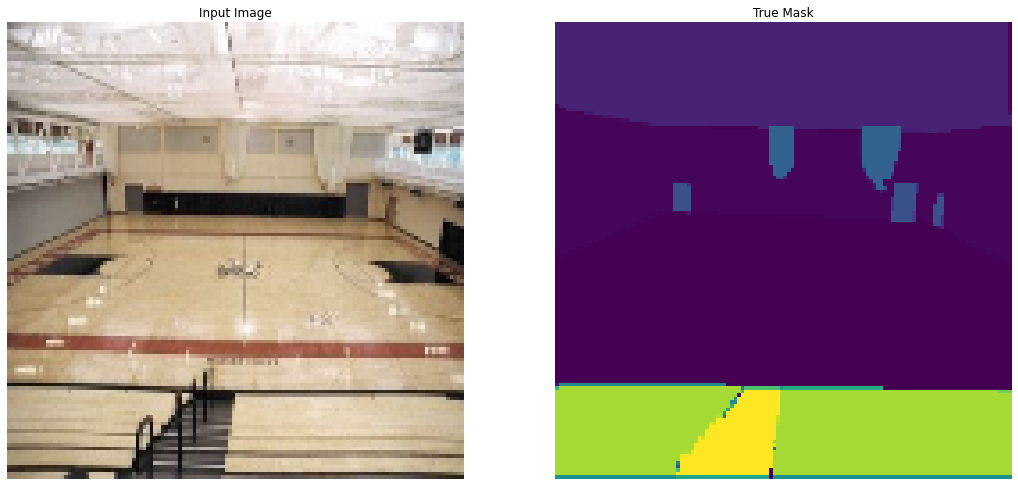

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display([sample_image[0], sample_mask[0]])

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 


As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0...150}. The network here is outputting 151 channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
model = unet_model(N_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

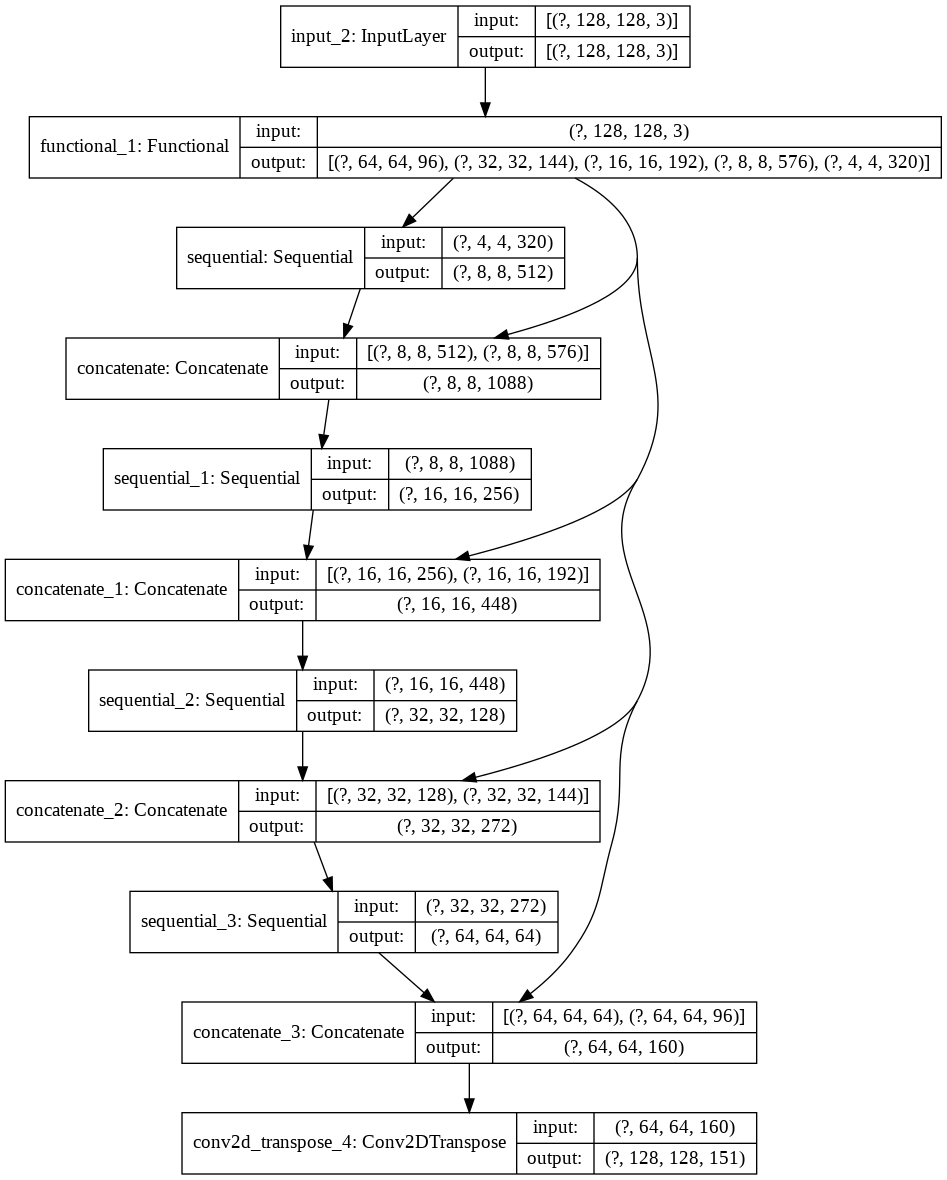

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            one_img_batch = image[0][tf.newaxis, ...]
            inference = model.predict(one_img_batch)
            pred_mask = create_mask(inference)
            display([image[0], mask[0], pred_mask[0]])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display([sample_image[0], sample_mask[0],
                        pred_mask[0]])

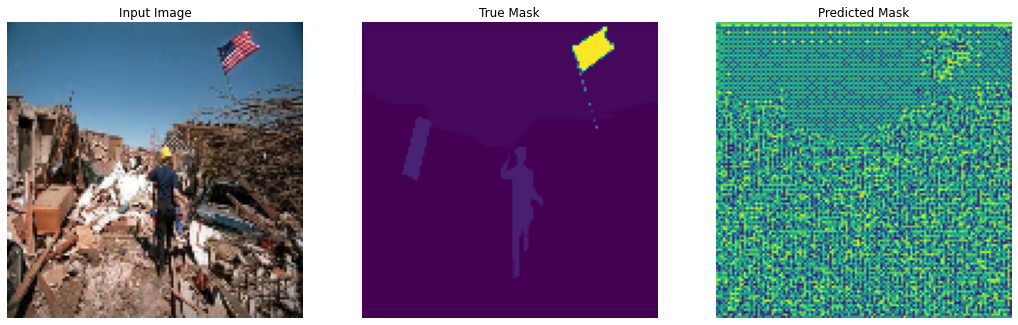

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

## Simple training loop

In [ ]:
EPOCHS = 1

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

In [ ]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

4042/4042 [==============================] - 149s 37ms/step - loss: 2.1804 - accuracy: 0.4780 - val_loss: 1.8813 - val_accuracy: 0.5334


## Training loop
Callbacks will be used to show the output of the model compared to the original image and the ground truth after each epochs.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.5981 - accuracy: 0.5837

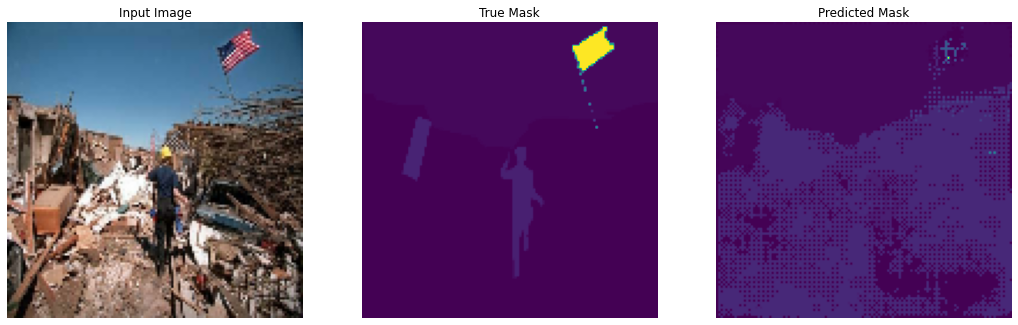


Sample Prediction after epoch 1

4042/4042 [==============================] - 161s 40ms/step - loss: 1.5981 - accuracy: 0.5837 - val_loss: 1.6342 - val_accuracy: 0.5782
Epoch 2/20
4042/4042 [==============================] - ETA: 0s - loss: 1.5742 - accuracy: 0.5886

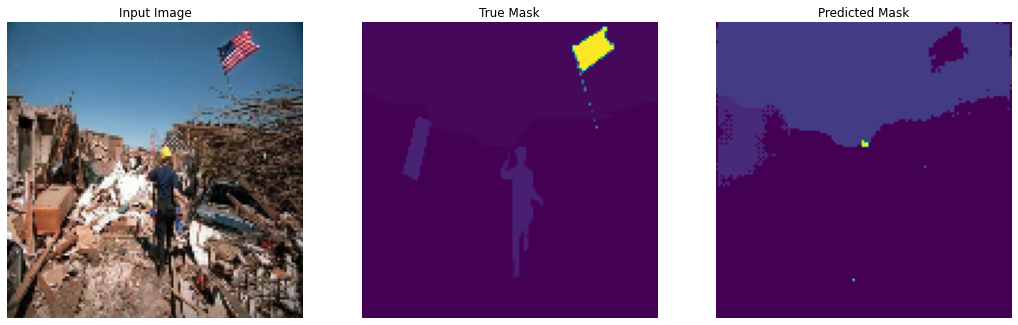


Sample Prediction after epoch 2

4042/4042 [==============================] - 160s 40ms/step - loss: 1.5742 - accuracy: 0.5886 - val_loss: 1.6387 - val_accuracy: 0.5728
Epoch 3/20
4042/4042 [==============================] - ETA: 0s - loss: 1.5515 - accuracy: 0.5932

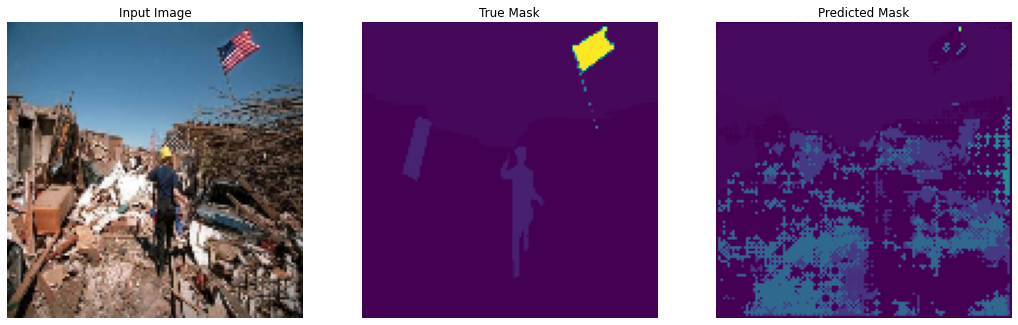


Sample Prediction after epoch 3

4042/4042 [==============================] - 160s 40ms/step - loss: 1.5515 - accuracy: 0.5932 - val_loss: 1.6289 - val_accuracy: 0.5817
Epoch 4/20
4042/4042 [==============================] - ETA: 0s - loss: 1.5289 - accuracy: 0.5978

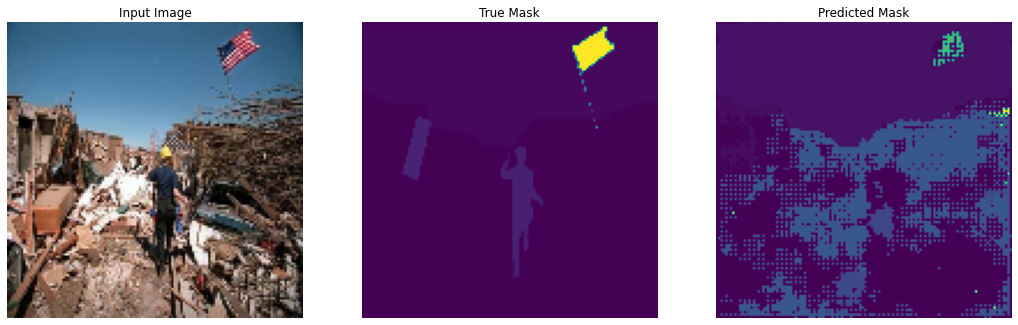


Sample Prediction after epoch 4

4042/4042 [==============================] - 160s 40ms/step - loss: 1.5289 - accuracy: 0.5978 - val_loss: 1.6018 - val_accuracy: 0.5854
Epoch 5/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.5104 - accuracy: 0.6019

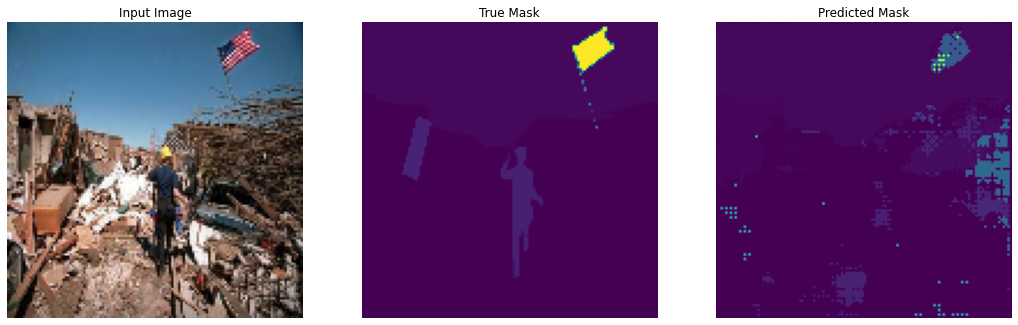


Sample Prediction after epoch 5

4042/4042 [==============================] - 160s 40ms/step - loss: 1.5104 - accuracy: 0.6019 - val_loss: 1.5995 - val_accuracy: 0.5840
Epoch 6/20
4042/4042 [==============================] - ETA: 0s - loss: 1.4879 - accuracy: 0.6071

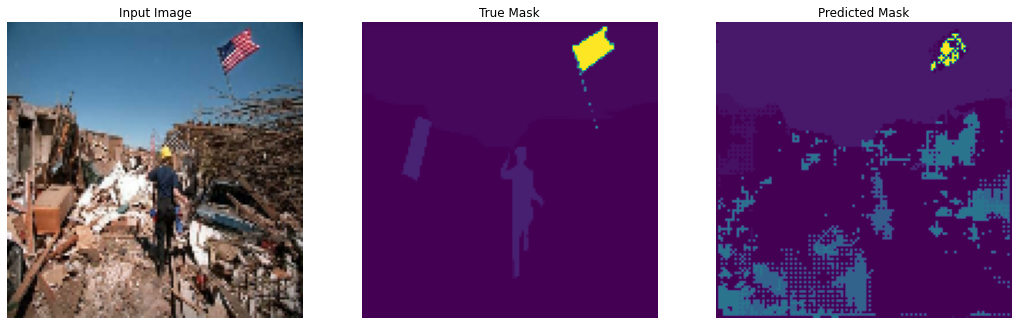


Sample Prediction after epoch 6

4042/4042 [==============================] - 160s 40ms/step - loss: 1.4879 - accuracy: 0.6071 - val_loss: 1.5842 - val_accuracy: 0.5888
Epoch 7/20
4042/4042 [==============================] - ETA: 0s - loss: 1.4724 - accuracy: 0.6113

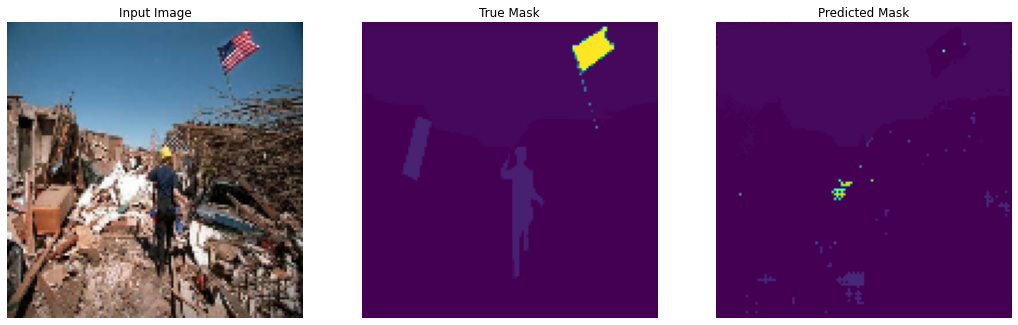


Sample Prediction after epoch 7

4042/4042 [==============================] - 160s 40ms/step - loss: 1.4724 - accuracy: 0.6113 - val_loss: 1.6111 - val_accuracy: 0.5835
Epoch 8/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.4507 - accuracy: 0.6157

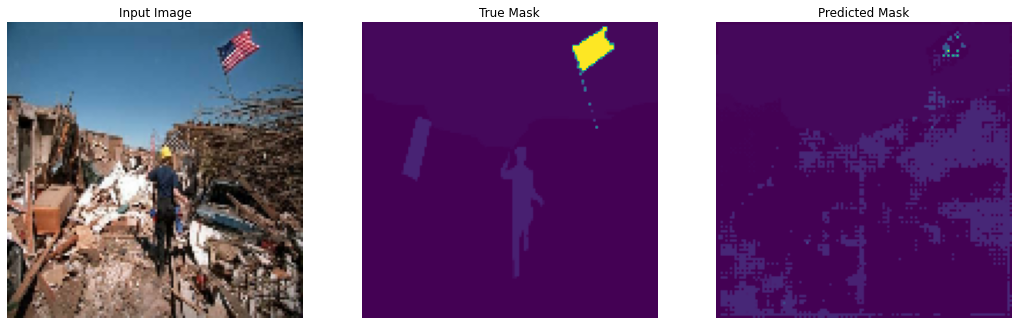


Sample Prediction after epoch 8

4042/4042 [==============================] - 160s 40ms/step - loss: 1.4507 - accuracy: 0.6157 - val_loss: 1.6211 - val_accuracy: 0.5852
Epoch 9/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.4337 - accuracy: 0.6200

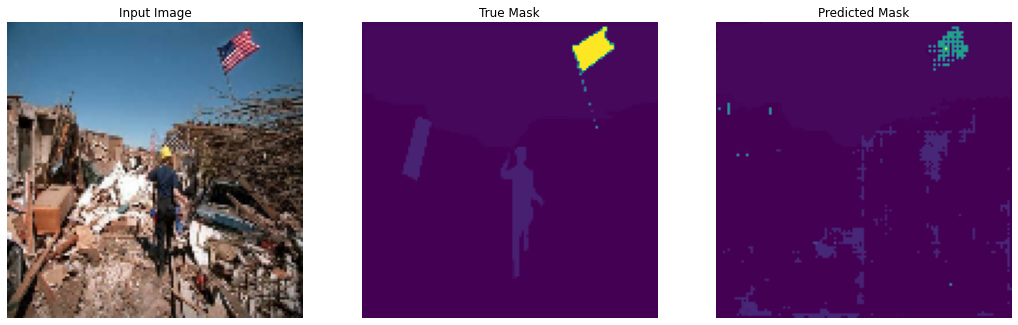


Sample Prediction after epoch 9

4042/4042 [==============================] - 160s 40ms/step - loss: 1.4338 - accuracy: 0.6200 - val_loss: 1.6196 - val_accuracy: 0.5873
Epoch 10/20
4042/4042 [==============================] - ETA: 0s - loss: 1.4186 - accuracy: 0.6238

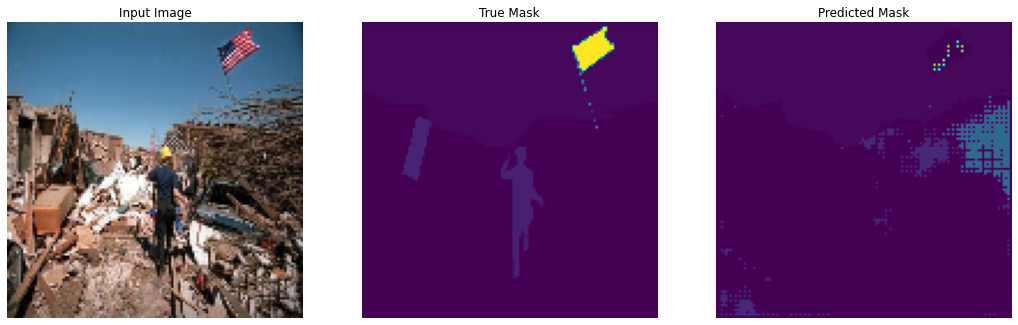


Sample Prediction after epoch 10

4042/4042 [==============================] - 160s 40ms/step - loss: 1.4186 - accuracy: 0.6238 - val_loss: 1.6295 - val_accuracy: 0.5763
Epoch 11/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.3972 - accuracy: 0.6284

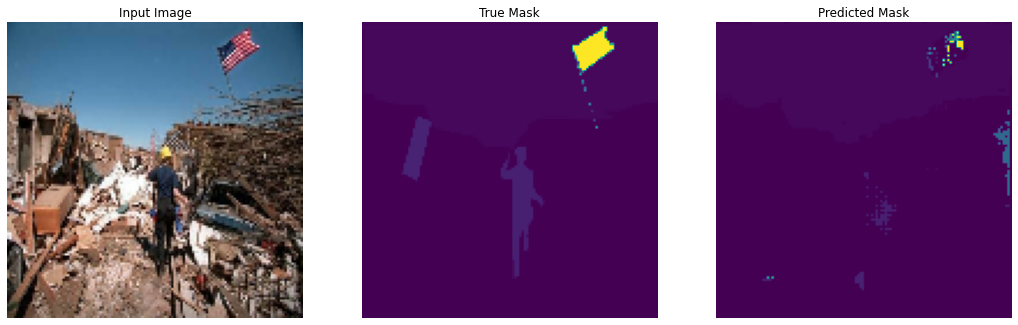


Sample Prediction after epoch 11

4042/4042 [==============================] - 161s 40ms/step - loss: 1.3972 - accuracy: 0.6284 - val_loss: 1.6308 - val_accuracy: 0.5844
Epoch 12/20
4042/4042 [==============================] - ETA: 0s - loss: 1.3842 - accuracy: 0.6319

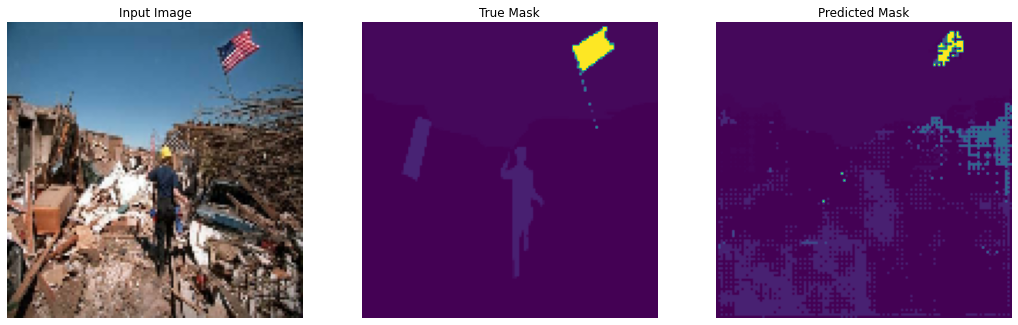


Sample Prediction after epoch 12

4042/4042 [==============================] - 160s 40ms/step - loss: 1.3842 - accuracy: 0.6319 - val_loss: 1.6204 - val_accuracy: 0.5869
Epoch 13/20
4042/4042 [==============================] - ETA: 0s - loss: 1.3656 - accuracy: 0.6365

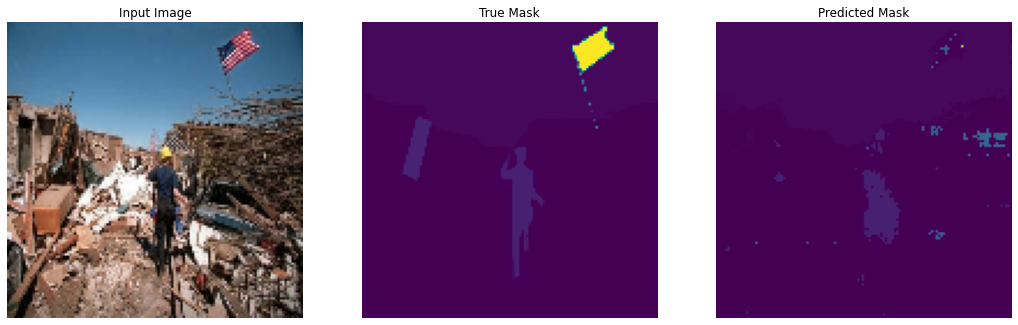


Sample Prediction after epoch 13

4042/4042 [==============================] - 160s 40ms/step - loss: 1.3656 - accuracy: 0.6365 - val_loss: 1.6131 - val_accuracy: 0.5861
Epoch 14/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.3514 - accuracy: 0.6395

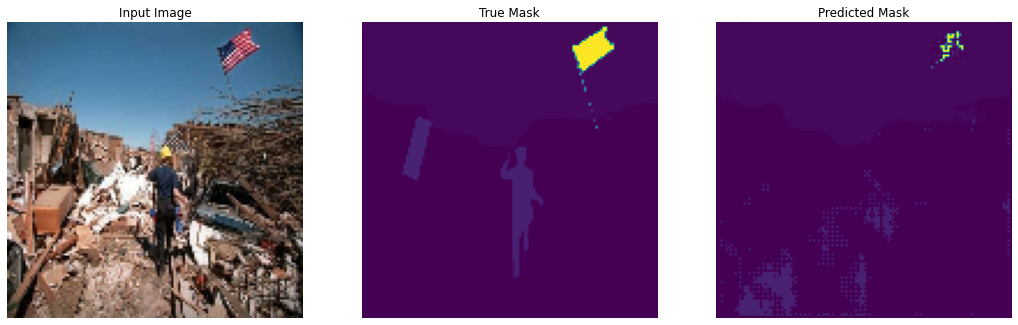


Sample Prediction after epoch 14

4042/4042 [==============================] - 160s 40ms/step - loss: 1.3514 - accuracy: 0.6395 - val_loss: 1.6105 - val_accuracy: 0.5904
Epoch 15/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.3338 - accuracy: 0.6447

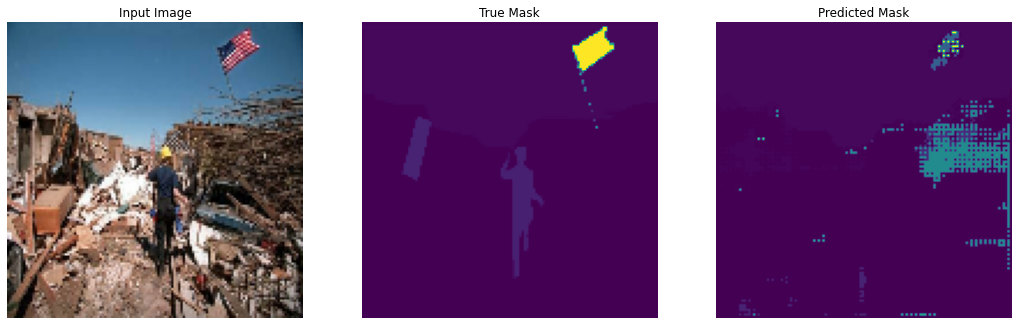


Sample Prediction after epoch 15

4042/4042 [==============================] - 160s 40ms/step - loss: 1.3338 - accuracy: 0.6447 - val_loss: 1.6485 - val_accuracy: 0.5822
Epoch 16/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.3229 - accuracy: 0.6473

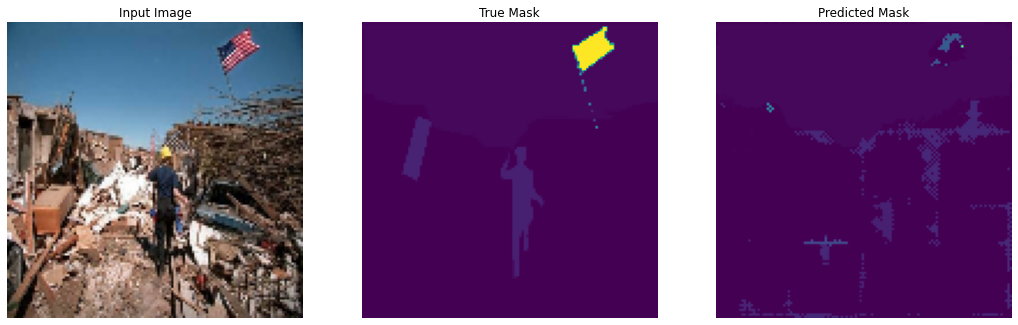


Sample Prediction after epoch 16

4042/4042 [==============================] - 160s 40ms/step - loss: 1.3229 - accuracy: 0.6473 - val_loss: 1.6377 - val_accuracy: 0.5872
Epoch 17/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.3054 - accuracy: 0.6518

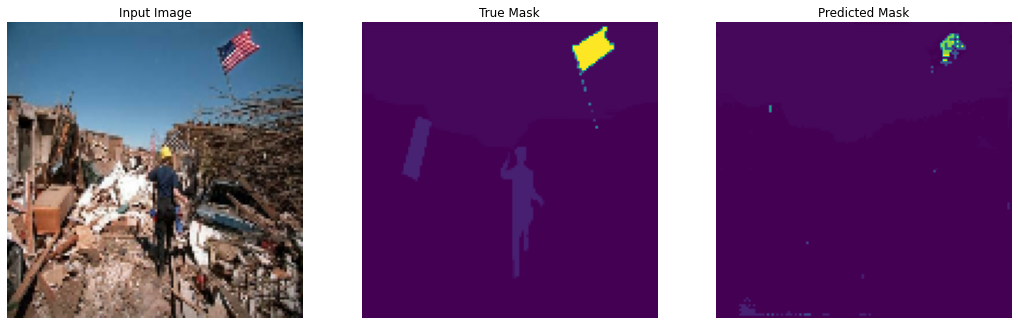


Sample Prediction after epoch 17

4042/4042 [==============================] - 160s 40ms/step - loss: 1.3055 - accuracy: 0.6518 - val_loss: 1.6264 - val_accuracy: 0.5913
Epoch 18/20
4041/4042 [============================>.] - ETA: 0s - loss: 1.2908 - accuracy: 0.6556

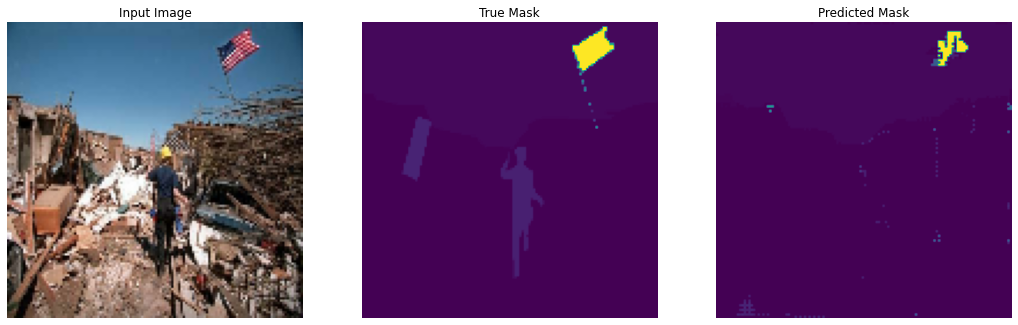


Sample Prediction after epoch 18

4042/4042 [==============================] - 160s 40ms/step - loss: 1.2908 - accuracy: 0.6556 - val_loss: 1.6849 - val_accuracy: 0.5719
Epoch 19/20
4042/4042 [==============================] - ETA: 0s - loss: 1.2774 - accuracy: 0.6587

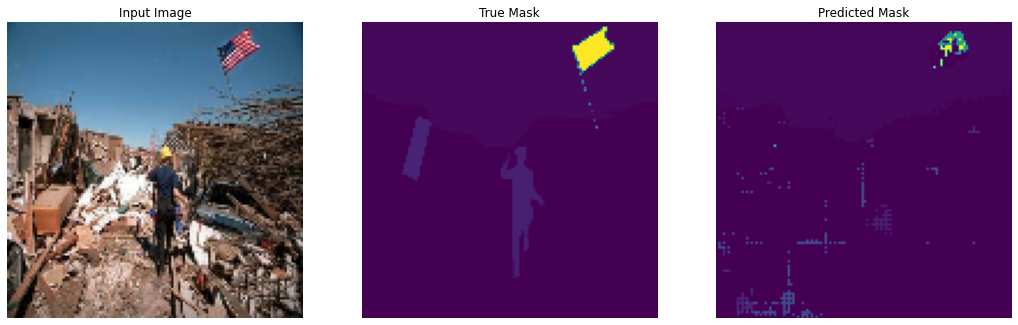


Sample Prediction after epoch 19

4042/4042 [==============================] - 160s 40ms/step - loss: 1.2774 - accuracy: 0.6587 - val_loss: 1.6570 - val_accuracy: 0.5846
Epoch 20/20
4042/4042 [==============================] - ETA: 0s - loss: 1.2649 - accuracy: 0.6620

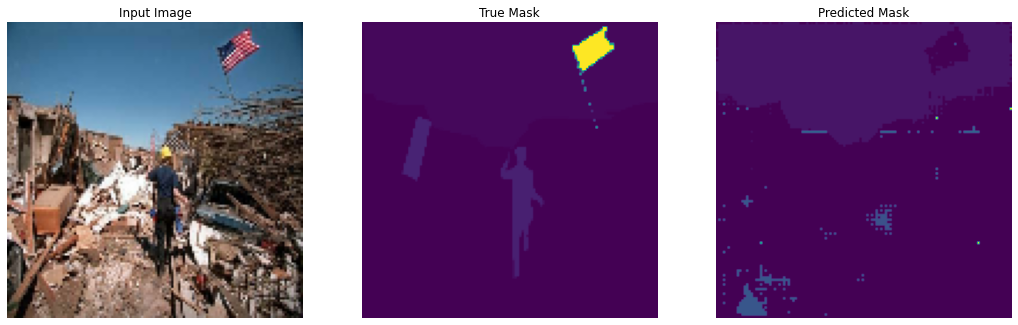


Sample Prediction after epoch 20

4042/4042 [==============================] - 160s 40ms/step - loss: 1.2649 - accuracy: 0.6620 - val_loss: 1.7038 - val_accuracy: 0.5763


In [ ]:
EPOCHS = 20

model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks=[DisplayCallback()])

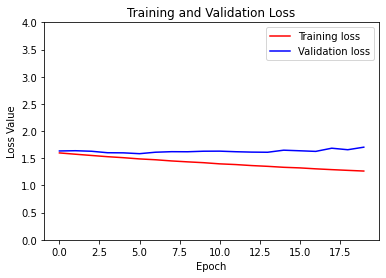

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 4])
plt.legend()
plt.show()

## Make predictions

Show some predictions on the validation dataset to see result after training for 20 epochs.

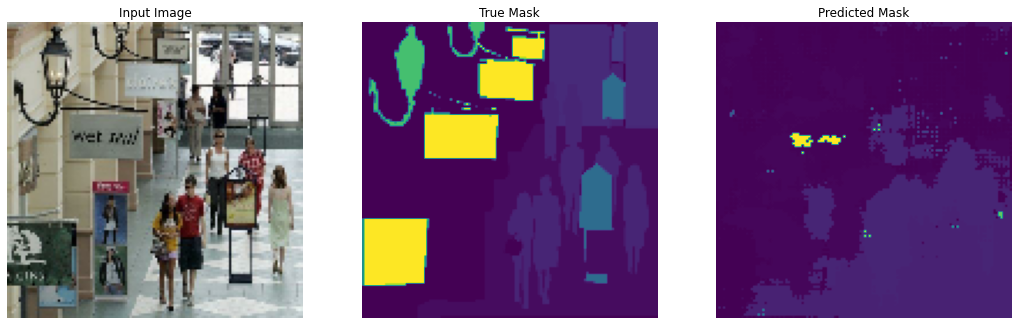

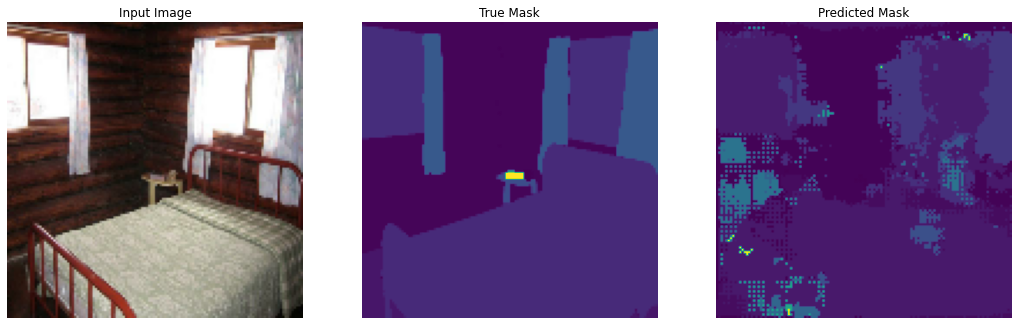

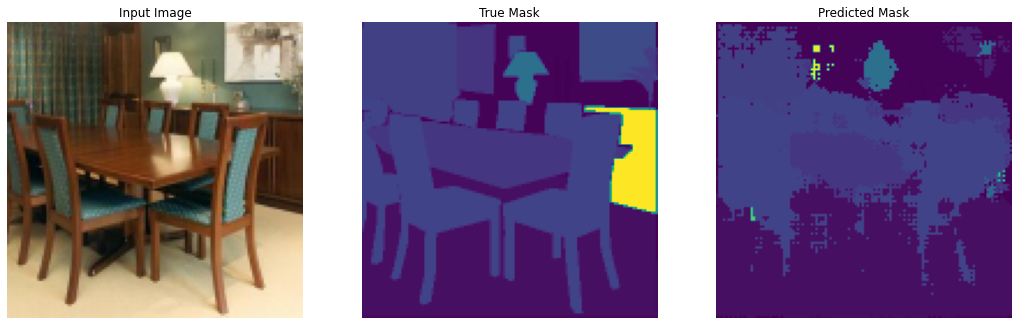

In [ ]:
show_predictions(dataset['val'], 3)